In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings(action="ignore")
from matplotlib.image import imread
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
base_dir = "/content/drive/MyDrive/data set/cell_images"
os.listdir(base_dir)

['Uninfected', 'Parasitized']

In [ ]:
parasitized_dir = "/content/drive/MyDrive/data set/cell_images/Parasitized"
uninfected_dir = "/content/drive/MyDrive/data set/cell_images/Uninfected"

print ('Total of Parasitized cell images: ', len(os.listdir(parasitized_dir)))
print ('Total of Uninfected cell images: ', len(os.listdir(uninfected_dir)))

Total of Parasitized cell images:  3000
Total of Uninfected cell images:  3000


In [ ]:
image_shape = parasitized_dir + "/C170P131ThinF_IMG_20151119_120233_cell_188.png"
print("Shape of image: ",imread(image_shape).shape)

Shape of image:  (124, 118, 3)


In [ ]:
# import os
# import numpy as np
# from tensorflow.keras.preprocessing.image import img_to_array, load_img
# from tensorflow.image import resize
# from PIL import Image
# from io import BytesIO

# # Function to preprocess a list of images
# def preprocess_image_folder(folder_path, filenames, target_size=(150, 150)):
#     images = []
#     for filename in filenames:
#         # Construct the full path to the image
#         file_path = os.path.join(folder_path, filename)
#         try:
#             # Load the image
#             img = Image.open(file_path)
#             # Convert the image to a NumPy array
#             img_array = np.array(img)
#             # Resize the image
#             img_array = resize(img_array, target_size)
#             # Normalize the pixel values to be in the range [0, 1]
#             img_array = img_array / 255.0
#             images.append(img_array)
#         except Exception as e:
#             continue
#     return np.array(images)


# # Get the list of filenames in the infected and uninfected folders
# infected_images = os.listdir(parasitized_dir)
# uninfected_images = os.listdir(uninfected_dir)

# # Preprocess infected and uninfected images
# preprocessed_infected_images = preprocess_image_folder(parasitized_dir, infected_images)
# preprocessed_uninfected_images = preprocess_image_folder(uninfected_dir, uninfected_images)


In [ ]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.image import resize

# Function to preprocess a list of images
def preprocess_images(filenames, folder_path, target_size=(150, 150)):
    images = []
    batch_size = 32  # Adjust the batch size as needed

    for i in range(0, len(filenames), batch_size):
        batch_filenames = filenames[i:i + batch_size]
        batch_images = []

        for filename in batch_filenames:
            file_path = os.path.join(folder_path, filename)
            try:
                # Load the image
                img = Image.open(file_path)
                # Resize the image
                img = resize(img, target_size)
                # Convert the image to a NumPy array and normalize
                img_array = np.array(img) / 255.0
                batch_images.append(img_array)
            except Exception as e:
              continue;

        images.extend(batch_images)

    return np.array(images)


# Get the list of filenames in the infected and uninfected folders
infected_images = os.listdir(parasitized_dir)
uninfected_images = os.listdir(uninfected_dir)

# Preprocess infected and uninfected images
preprocessed_infected_images = preprocess_images(infected_images, parasitized_dir)
preprocessed_uninfected_images = preprocess_images(uninfected_images, uninfected_dir)


In [ ]:
print(len(preprocessed_infected_images))
print(len(preprocessed_uninfected_images))
print(preprocessed_infected_images.shape)
print(preprocessed_uninfected_images.shape)
print(type(preprocessed_infected_images))

2999
2999
(2999, 150, 150, 3)
(2999, 150, 150, 3)
<class 'numpy.ndarray'>


In [ ]:
from sklearn.model_selection import train_test_split

# Concatenate the preprocessed infected and uninfected images
all_images = np.concatenate([preprocessed_infected_images, preprocessed_uninfected_images], axis=0)

# Create labels for the images: 1 for infected, 0 for uninfected
infected_labels = np.ones(preprocessed_infected_images.shape[0])
uninfected_labels = np.zeros(preprocessed_uninfected_images.shape[0])
all_labels = np.concatenate([infected_labels, uninfected_labels])

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Check the shapes of the resulting datasets
print("Training set shapes:", X_train.shape, y_train.shape)
print("Validation set shapes:", X_val.shape, y_val.shape)
print("Testing set shapes:", X_test.shape, y_test.shape)


Training set shapes: (3598, 150, 150, 3) (3598,)
Validation set shapes: (1200, 150, 150, 3) (1200,)
Testing set shapes: (1200, 150, 150, 3) (1200,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = tf.keras.models.Sequential([
    #first_convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    #second_convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #third_convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #fourth_convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=5,             # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore weights from the epoch with the best validation loss
)

In [ ]:
history = model.fit(
      X_train,  # Training data
      y_train,  # Training labels
      epochs=20,
      steps_per_epoch = 50,
      batch_size=32,  # Specify your batch size
      validation_data=(X_val, y_val),  # Validation data
      callbacks=[early_stopping] ,
      verbose=True,
      )

Epoch 1/20
50/50 [==============================] - 107s 2s/step - loss: 0.6504 - accuracy: 0.5944 - val_loss: 0.7607 - val_accuracy: 0.5992
Epoch 2/20
50/50 [==============================] - 103s 2s/step - loss: 0.5254 - accuracy: 0.7694 - val_loss: 0.4089 - val_accuracy: 0.8850
Epoch 3/20
50/50 [==============================] - 99s 2s/step - loss: 0.2624 - accuracy: 0.9267 - val_loss: 0.2300 - val_accuracy: 0.9250
Epoch 4/20
50/50 [==============================] - 105s 2s/step - loss: 0.2325 - accuracy: 0.9350 - val_loss: 0.1693 - val_accuracy: 0.9408
Epoch 5/20
50/50 [==============================] - 106s 2s/step - loss: 0.1474 - accuracy: 0.9576 - val_loss: 0.1593 - val_accuracy: 0.9500
Epoch 6/20
50/50 [==============================] - 104s 2s/step - loss: 0.1450 - accuracy: 0.9600 - val_loss: 0.1887 - val_accuracy: 0.9383
Epoch 7/20
50/50 [==============================] - 101s 2s/step - loss: 0.1295 - accuracy: 0.9570 - val_loss: 0.1473 - val_accuracy: 0.9500
Epoch 8/20
50/

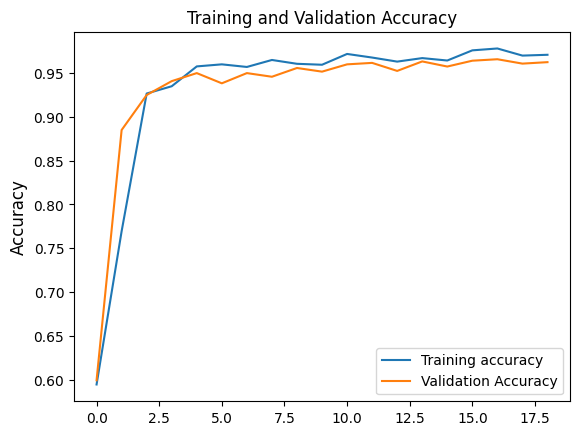

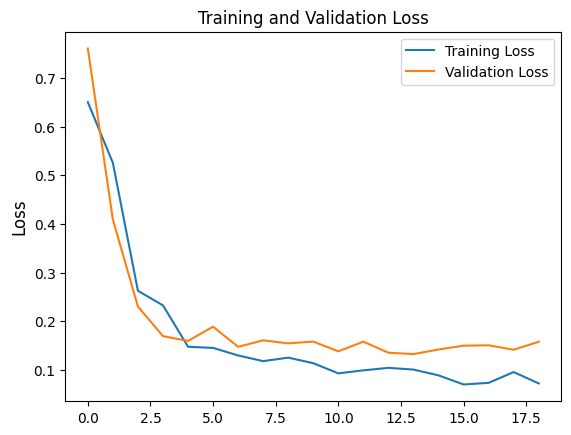

In [ ]:
acc = history.history["accuracy"]
loss = history.history["loss"]

val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

plt.plot(acc,label="Training accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend()
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.show()

plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend()
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss",fontsize=12)
plt.show()

In [ ]:
model.evaluate(X_test, y_test, verbose=1)
predictions = model.predict(X_test)



38/38 [==============================] - 17s 458ms/step
1200
[[0.99999726]
 [0.6596812 ]
 [0.8450529 ]
 ...
 [0.99884427]
 [0.01244817]
 [0.01714899]]


In [ ]:
print(len(predictions))
print(predictions)
print(predictions.shape)

1200
[[0.99999726]
 [0.6596812 ]
 [0.8450529 ]
 ...
 [0.99884427]
 [0.01244817]
 [0.01714899]]
(1200, 1)


In [ ]:
# Assuming predictions is a numpy array containing the probability values
threshold = 0.5
binary_pred = (predictions > threshold).astype(int)

print(binary_pred)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]


              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       591
         1.0       0.95      0.96      0.95       609

    accuracy                           0.95      1200
   macro avg       0.95      0.95      0.95      1200
weighted avg       0.95      0.95      0.95      1200

Confusion Matrix:
[[560  31]
 [ 27 582]]


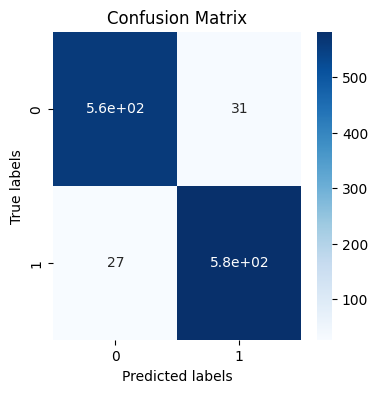

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,binary_pred))
cm = confusion_matrix(y_test, binary_pred)

print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(4, 4))
sns.heatmap(confusion_matrix(y_test, binary_pred), annot=True, cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

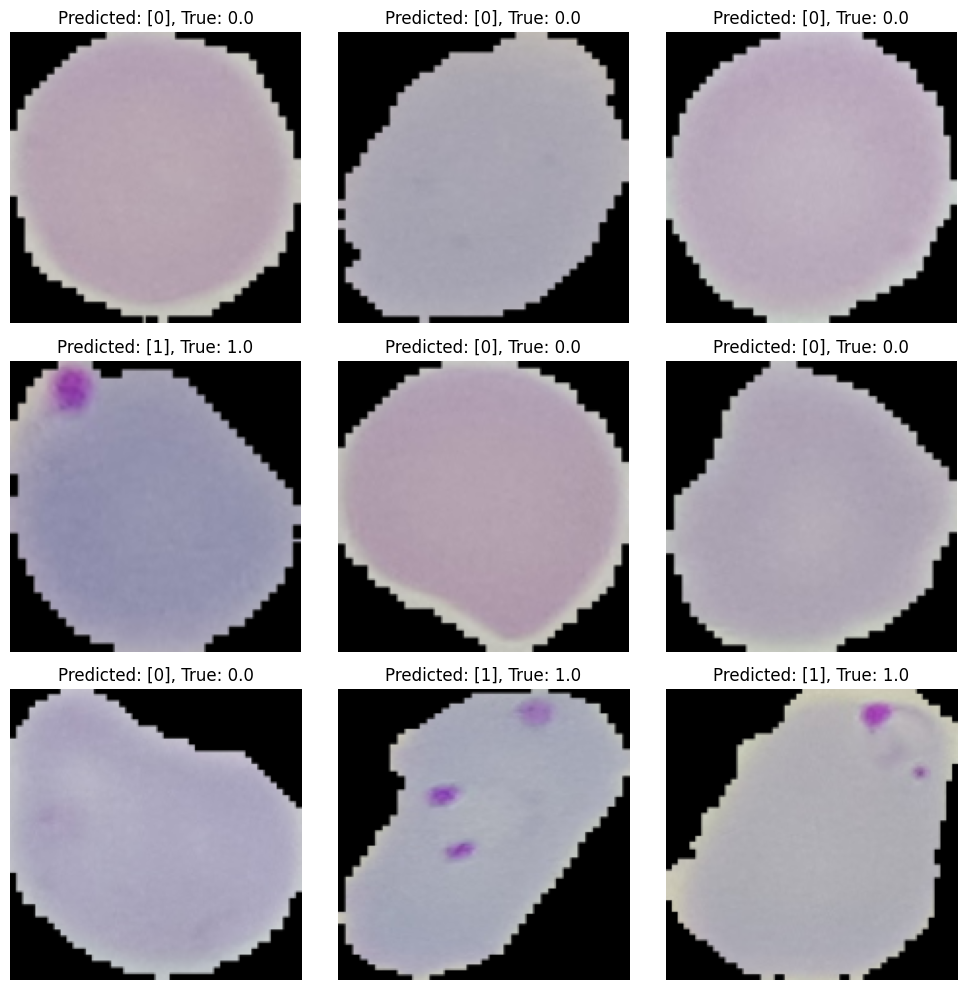

In [ ]:
import random

# Create a figure and axes for subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Iterate over each subplot and randomly select an image
for i in range(3):
    for j in range(3):
        # Choose a random index from X_test
        random_index = random.randint(0, len(X_test) - 1)

        # Get the corresponding image from X_test and its true label
        random_image = X_test[random_index]
        true_label = y_test[random_index]
        predicted_label = binary_pred[random_index]

        # Plot the image in the current subplot
        ax = axes[i, j]
        ax.imshow(random_image, cmap='gray')
        ax.set_title(f'Predicted: {predicted_label}, True: {true_label}')
        ax.axis('off')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [ ]:
# Save the entire model to Google Drive
model.save('/content/drive/MyDrive/data set')


In [ ]:
# # Load the saved model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/data set/')

# # Preprocess the input data (e.g., x_test) if necessary

# # Generate predictions on the new data
model.evaluate(X_test, y_test, verbose=1)
predictions = loaded_model.predict(X_test)


38/38 [==============================] - 18s 483ms/step
